In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [87]:
def make_clusters(
        n: int = 500, 
        m: int = 2, 
        k: int = 3, 
        bounds: tuple = (-10, 10),
        scale: float = 1,
        seed: int = 42) -> (np.ndarray, np.ndarray):
    """
    creates some clustered data

    inputs:
        n: int
            number of observations
        m: int
            number of features
        k: int
            number of clusters
        bounds: tuple
            minimum and maximum bounds for cluster grid
        scale: float
            standard deviation of normal distribution
        seed: int
            random seed

    outputs:
        (np.ndarray, np.ndarray)
            returns a 2D matrix of `n` observations and `m` features that are clustered into `k` groups
            returns a 1D array of `n` size that defines the cluster origin for each observation
    """
    np.random.seed(seed)
    assert k <= n

    labels = np.sort(np.random.randint(0, k, size=n))
    centers = np.random.uniform(bounds[0], bounds[1], size=(k,m))
    mat = np.vstack([
        np.random.normal(
            loc=centers[idx], 
            scale=scale, 
            size=(np.sum(labels==idx), m))
        for idx in np.arange(0, k)])

    return mat, labels

mat_test, label_test = make_clusters(500, 2, 3, (-10, 10), 1, 42)

print(mat_test)

[[ -9.24761985   9.80496848   0.52222444   1.84818755   3.01030056]
 [-10.56199342   8.12368855  -1.24658462   0.89784855   3.24925   ]
 [ -8.46369784   7.3775018    1.57572035  -0.19365137   2.44104454]
 ...
 [  4.74669116   3.43176452   0.69632342  -7.09631388   6.24462891]
 [  6.56228256   2.32544322   1.01862426  -6.33955859   4.86980348]
 [  5.01587388   3.74266416   1.75407067  -7.91884278   5.94565065]]


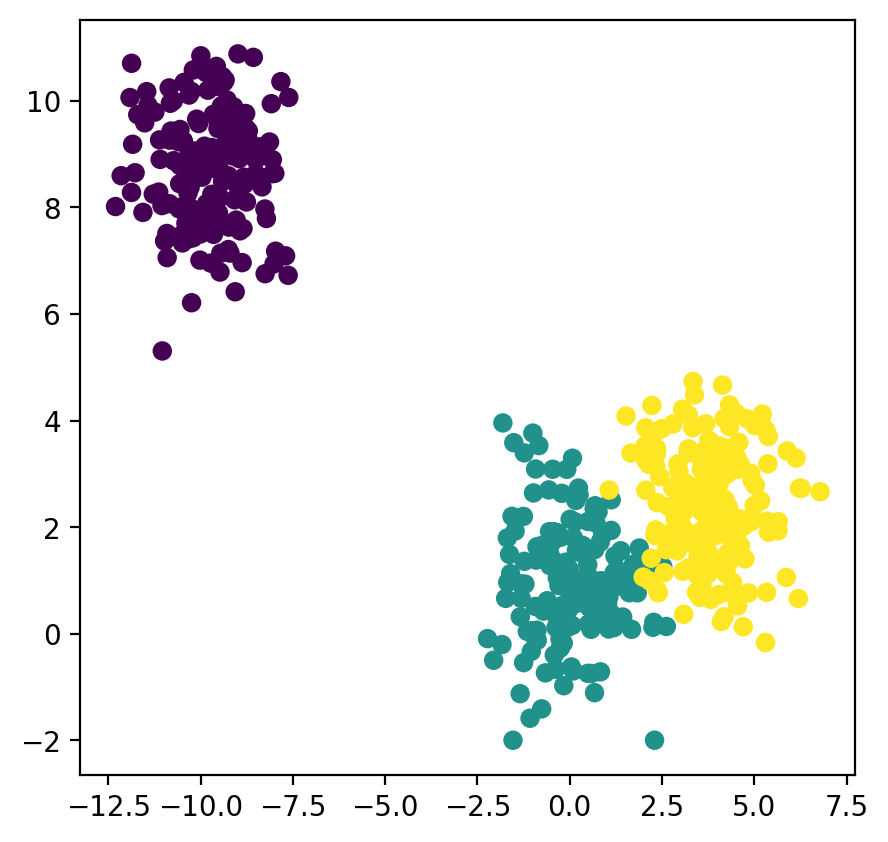

In [81]:
def plot_clusters(
        mat: np.ndarray, 
        labels: np.ndarray, 
        filename: str =None):
    """
    inputs:
        mat: np.ndarray
            a 2D matrix where each row is an observation and each column is a feature
        labels: np.ndarray
            a 1D array where each value represents an integer cluster that an observation belongs to
        filename: str
            an optional value to save a figure to a file
    """

    plt.figure(figsize=(5,5), dpi=200)
    plt.scatter(
        mat[:,0], 
        mat[:,1], 
        c=labels)

    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()
    
plot_clusters(mat_test, label_test)

In [13]:
np.random.uniform(-10, 10, size=(3,2))

array([[-8.22465212,  9.23331472],
       [ 2.69920091,  5.0967564 ],
       [-6.59044124, -1.81044294]])

In [90]:

class KMeans:
    def __init__(
            self,
            k: int,
            metric: str = "euclidean",
            tol: float = 1e-6,
            max_iter: int = 100):
        """
        inputs:
            k: int
                the number of centroids to use in cluster fitting
            metric: str
                the name of the distance metric to use
            tol: float
                the minimum error tolerance from previous error during optimization to quit the model fit
            max_iter: int
                the maximum number of iterations before quitting model fit
        """
        self.k = k
        self.metric = metric
        self.tol = tol
        self.max_iter = max_iter
        
        # model should not run if k<=0
        if self.k<=0:
            raise ValueError("k must be greater than zero")
    
    def fit(self, mat: np.ndarray):
        """
        fits the kmeans algorithm onto a provided 2D matrix

        inputs: 
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features
        """
        
        # model should not run if k > number of observations
        if self.k > np.shape(mat)[0]:
            raise ValueError("k must be less than the number of observations in the array")

        # create random centers
        centers = np.random.uniform(np.min(mat), np.max(mat), size=(self.k,2))
        
        # set baseline values
        i=1
        mse=1
        mse_diff=1
        
        # iteratively select new centers
        while i<self.max_iter and mse_diff>self.tol:  
            # assign points to each cluster based on their distance to the centers
            dist_mat = cdist(mat, centers, metric=self.metric) # calculate distances from each point to each center, using supplied metric
            calc_labels = np.argmin(dist_mat, axis=1) # find index of minmum value in each row
            
            # calculate error - calculate squared distance from each point to its corresponding centroid, 
            # using the supplied metric, then take the mean of those values
            old_mse = mse
            mse = np.mean(np.square(np.choose(calc_labels, dist_mat.T))) # numpy.choose which constructs an array from an index array - https://stackoverflow.com/questions/17074422/select-one-element-in-each-row-of-a-numpy-array-by-column-indices
            mse_diff = abs(old_mse-mse)
            
            # update centers based on cluster membership of datapoints
            centers = np.array([mat[calc_labels==j].mean(0) for j in range(self.k)])
            
            # increment
            i+=1
        
        # store centers, labels, and final mse
        self.centers = centers
        self.labels = calc_labels
        self.mse = mse
        
    def predict(self, mat: np.ndarray) -> np.ndarray:
        """
        predicts the cluster labels for a provided 2D matrix

        inputs: 
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features

        outputs:
            np.ndarray
                a 1D array with the cluster label for each of the observations in `mat`
        """
        return self.labels

    def get_error(self) -> float:
        """
        returns the final squared-mean error of the fit model

        outputs:
            float
                the squared-mean error of the fit model
        """
        return self.mse

    def get_centroids(self) -> np.ndarray:
        """
        returns the centroid locations of the fit model

        outputs:
            np.ndarray
                a `k x m` 2D matrix representing the cluster centroids of the fit model
        """
        return self.centers

clusters, labels = make_clusters(k=4, scale=1)
km = KMeans(k=4)
km.fit(clusters)
km.predict(clusters)


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [71]:
a=[[0,3], [1,3], [2,7]]
b=[[4,0],[4,0]]
#cdist(a,b)
np.argmin(b, axis=1)
np.shape(a)[0]

3

In [37]:
rseed=2
n_clusters=3
X=clusters
rng = np.random.RandomState(rseed)
i = rng.permutation(X.shape[0])[:n_clusters]
centers = X[i]
i

array([129, 280, 440])

In [50]:
a=5
old_a=a
a=6
print(a)
print(old_a)

6
5
